## SIMULATION OF SIR INFECTIOUS DISEASE MODEL FOR COVID-19

#### Author: Yiran Jing

### Content:
1. China Total
2. Ex-Hubei
3. Hubei
4. Ex-China

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
import pandas
from math import *
import datetime
import matplotlib.dates as mdates
from Dynamic_SIR_model import *
from helper_fun_epi_model import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Some assumptions
China_population = 1400000000
Hubei_population = 58500000

### Load data and clean data

In [3]:
## Load data 
df = pd.read_csv("../data/daily_time_series_data_JHU.csv").rename(columns={"Date": "date"})

"""
Data Cleaning 
"""
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

first_day = datetime.datetime(2019, 12, 8) # the time when detected the first case (2019-12-08)
df['Days'] = (df['date'] - first_day).dt.days

In [4]:
## Dataset preperation
df['R'] = df['Deaths'] + df['Recovered']
df["I"] = df['Confirmed'] - df['R'] # net confirmed case
SIR_data = df[['date', 'Days','Country','Province','I','R']]
#SIR_data.tail(3)

In [5]:
Sum_country = SIR_data.groupby(['Country','date','Days'])['I', 'R'].sum().reset_index()
# China total
# Use data before 2020-02-14 for train model
China_df = Sum_country[Sum_country['Country'] =='China']
China_total = China_df[China_df['date'] < datetime.datetime(2020, 2, 14)] 

### Estimate China Total

In [6]:
Dynamic_SEIR1 = Train_Dynamic_SIR(epoch = 10000, data = China_total, 
                 population = 1400000000, rateIR=1/14, c = 1, b = -10, alpha = 0.08)

In [7]:
estimation_df = Dynamic_SEIR1.train() 
est_beta = Dynamic_SEIR1.rateSI
est_alpha = Dynamic_SEIR1.alpha
est_b = Dynamic_SEIR1.b
est_c = Dynamic_SEIR1.c
population = Dynamic_SEIR1.numIndividuals

The loss in is 49231.783121441
The MAPE in the whole period is 0.01385949211752937


In [8]:
estimation_df.tail(2)

,Time,Estimated_Susceptible,Estimated_Infected,Estimated_Resistant
23,23.0,1.399953e+09,38202.187369,8945.285714
24,24.0,1.399937e+09,51670.295202,11313.214286


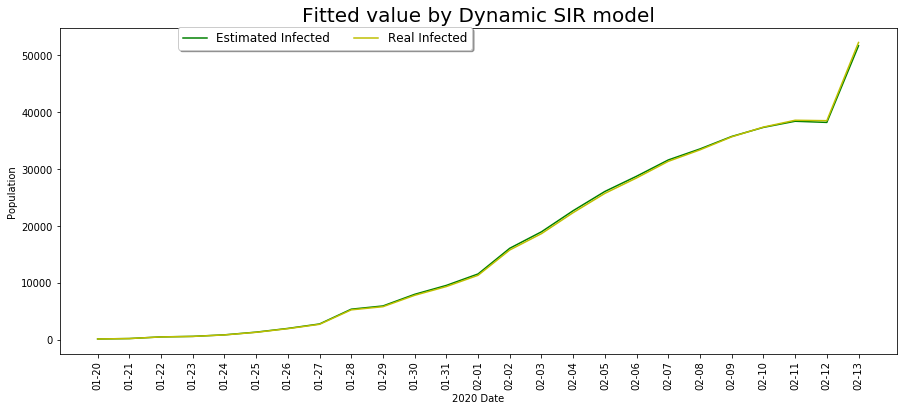

In [9]:
Dynamic_SEIR1.plot_fitted_result(China_total)

In [10]:
## use the last observation as the initial point in the new SEIR model

# I is the net confirmed cases (total confirmed case - heal - died)
I0 = list(China_total['I'])[-1]
R0 = list(China_total['R'])[-1]
S0 = population - I0 - R0

Maximum infected case:  52251


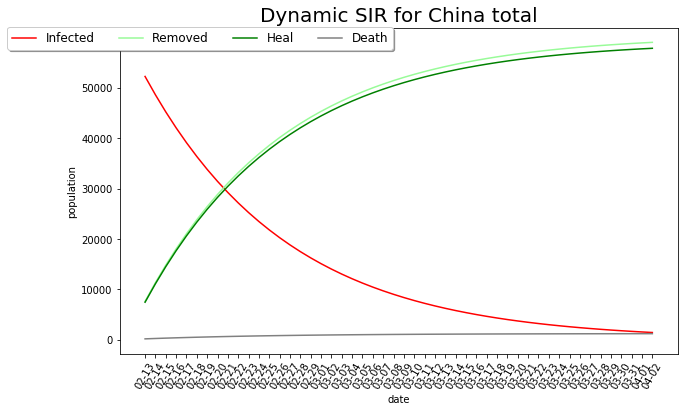

In [11]:
sir_new = dynamic_SIR(eons=50, Susceptible=S0, 
                    Infected=I0, Resistant=R0, rateIR=1/14, 
                    alpha = est_alpha, c = est_c, b = est_b, past_days = China_total['Days'].max())
result = sir_new.run(death_rate = 0.02) # assume death rate is 2%
sir_new.plot_noSuscep('Dynamic SIR for China total', 'population', 'date', starting_point = China_total['date'].max())

The MAMPE is: 
0.2947198023335001


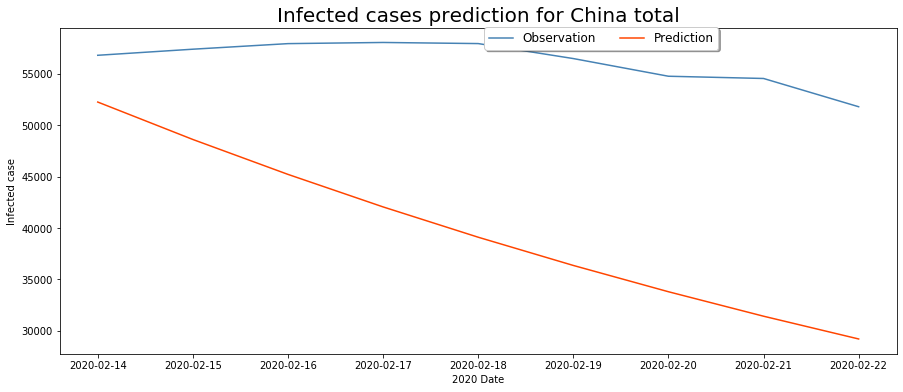

In [12]:
"""
Calculate MAPE test score using SEIR model result
"""
test = China_df[China_df['date'] >= datetime.datetime(2020, 2, 14)] 
plot_test_data_with_MAPE(test, result, 'Infected cases prediction for China total')

### Estimate Ex-Hubei

The loss in is 50279.34049095605
The MAPE in the whole period is 0.07058002331269543


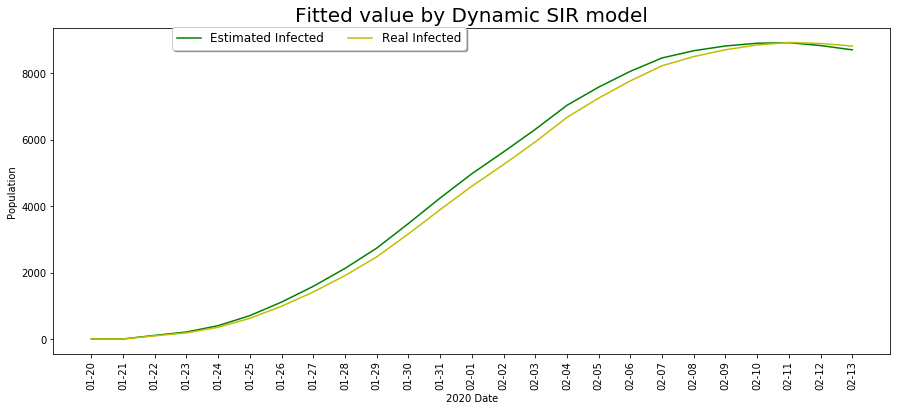

Maximum infected case:  8814


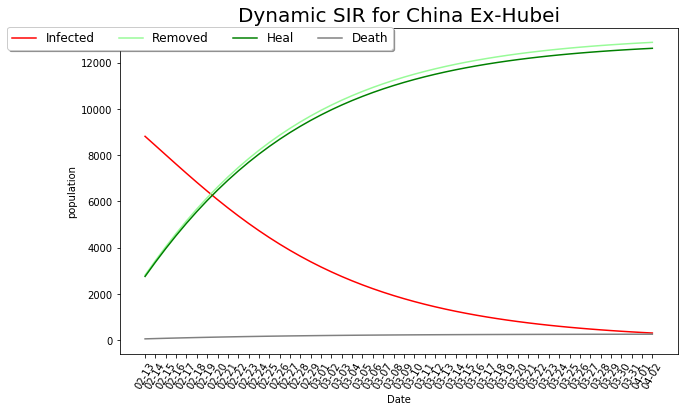

The MAMPE is: 
0.021338495656295094


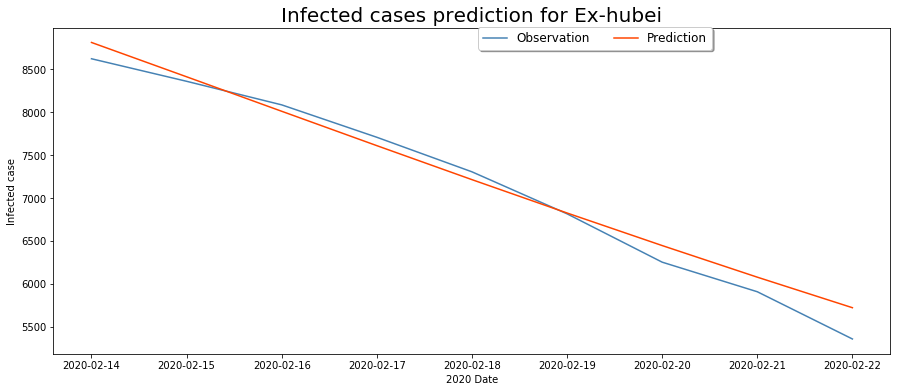

In [13]:
NotHubei_df = SIR_data[SIR_data['Province'] != 'Hubei']
NotHubei_df = NotHubei_df.groupby(['Country','date','Days'])['I', 'R'].sum().reset_index()
# China total
# Use data before 2020-02-14 for train model
NotHubei_df = NotHubei_df[NotHubei_df['Country'] =='China']
NotHubei = NotHubei_df[NotHubei_df['date'] < datetime.datetime(2020, 2, 14)] 


Dynamic_SEIR2 = Train_Dynamic_SIR(epoch = 10000, data = NotHubei, 
                 population = China_population-Hubei_population, rateIR=1/14)

estimation_df = Dynamic_SEIR2.train() 
est_beta = Dynamic_SEIR2.rateSI
est_alpha = Dynamic_SEIR2.alpha
est_b = Dynamic_SEIR1.b
est_c = Dynamic_SEIR1.c
population = Dynamic_SEIR2.numIndividuals

# Draw fitted result
Dynamic_SEIR2.plot_fitted_result(NotHubei)

## use the last observation as the initial point in the new SEIR model
I0 = list(NotHubei['I'])[-1]
R0 = list(NotHubei['R'])[-1]
S0 = population - I0 - R0

sir_new2 = dynamic_SIR(eons=50, Susceptible=S0, 
                    Infected=I0, Resistant=R0, rateIR=1/14, 
                    alpha = est_alpha, c = est_c, b = est_b)

result2= sir_new2.run(death_rate = 0.02) # assume death rate is 2%
sir_new2.plot_noSuscep('Dynamic SIR for China Ex-Hubei', 'population', 'Date', starting_point = NotHubei['date'].max())

"""
Calculate MAPE test score using SEIR model result
"""
test = NotHubei_df[NotHubei_df['date'] >= datetime.datetime(2020, 2, 14)] 

plot_test_data_with_MAPE(test, result2, 'Infected cases prediction for Ex-hubei')

## Estimate Hubei 
Currently cannot be done, since the data source I use has no exposed number for Hubei province. 


The MAMPE is: 
0.3369906744108236


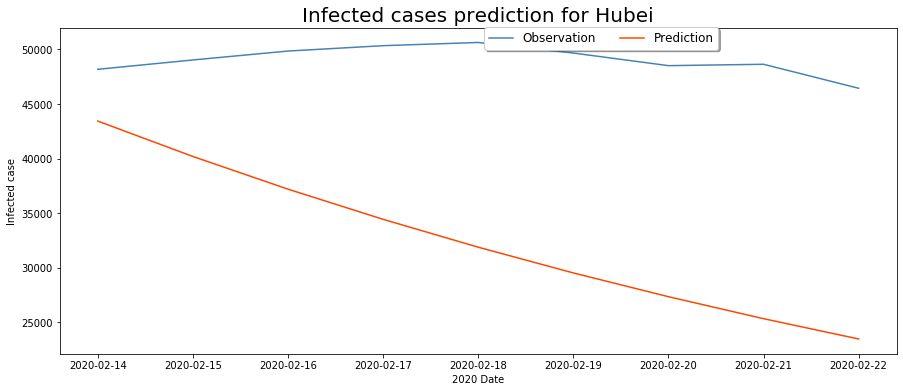

In [14]:
## estimted result 
result_Hubei = result - result2

test = SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)] 
test = test[test['Province'] == 'Hubei']


plot_test_data_with_MAPE(test, result_Hubei,'Infected cases prediction for Hubei')

## Ex-China

In [15]:
world_population = 7000000000 - China_population # assumption

The loss in is 423.24814337667084
The MAPE in the whole period is 0.12180292878937361


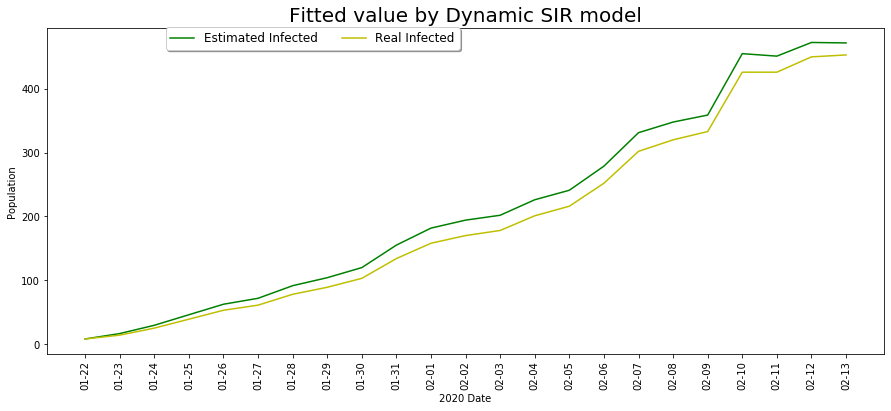

Maximum infected case:  453


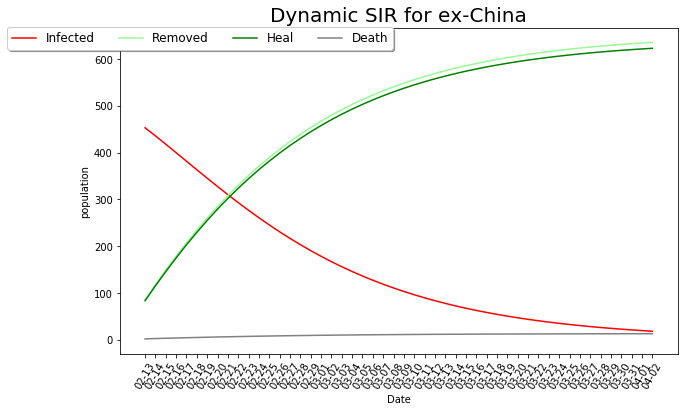

The MAMPE is: 
0.5013431794078205


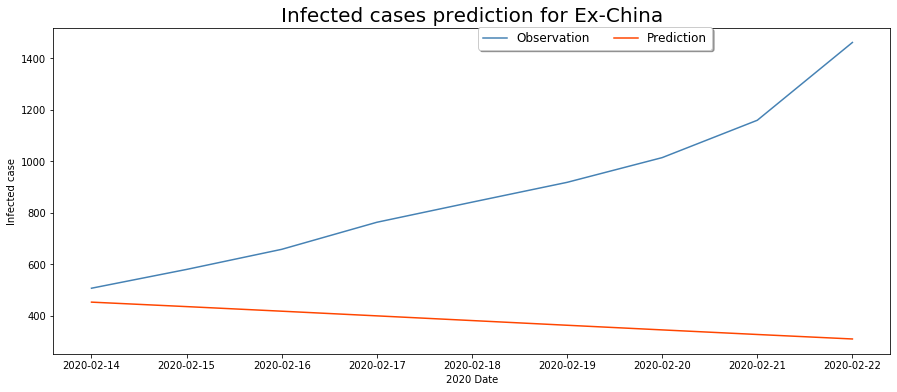

In [16]:
NotChina_df = SIR_data[SIR_data['Country'] != 'China']
NotChina_df = NotChina_df.groupby(['date','Days'])['I', 'R'].sum().reset_index()
# China total
# Use data before 2020-02-14 for train model
NotChina = NotChina_df[NotChina_df['date'] < datetime.datetime(2020, 2, 14)] 


Dynamic_SEIR2 = Train_Dynamic_SIR(epoch = 10000, data = NotChina, 
                 population = world_population, rateIR=1/14)

estimation_df = Dynamic_SEIR2.train() 
est_beta = Dynamic_SEIR2.rateSI
est_alpha = Dynamic_SEIR2.alpha
est_b = Dynamic_SEIR1.b
est_c = Dynamic_SEIR1.c
population = Dynamic_SEIR2.numIndividuals

# Draw fitted result
Dynamic_SEIR2.plot_fitted_result(NotChina)

## use the last observation as the initial point in the new SEIR model
I0 = list(NotChina['I'])[-1]
R0 = list(NotChina['R'])[-1]
S0 = population - I0 - R0

sir_new3 = dynamic_SIR(eons=50, Susceptible=S0, 
                    Infected=I0, Resistant=R0, rateIR=1/14, 
                    alpha = est_alpha, c = est_c, b = est_b)

result3= sir_new3.run(death_rate = 0.02) # assume death rate is 2%
sir_new3.plot_noSuscep('Dynamic SIR for ex-China', 'population', 'Date', starting_point = NotChina['date'].max())

"""
Calculate MAPE test score using SEIR model result
"""
test = NotChina_df[NotChina_df['date'] >= datetime.datetime(2020, 2, 14)] 

plot_test_data_with_MAPE(test, result3, 'Infected cases prediction for Ex-China')